In [1]:
from IPython.core.display import HTML
import pandas as pd
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
pd.options.display.max_columns = None
HTML("""
<style>
body
{
  filter: invert(1);
}
.notebook_app {
    background-color: black;
}
.container {
    width :100% !important;
}
</style>
""")

In [2]:
import pandas as pd
import numpy as np
import datetime
import copy
import time
import os
import json
import psycopg2


pd.set_option("display.precision",9)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings('ignore')

import logging
import string


# host = "172.16.100.156"
host = "192.168.151.157"
database = "bcast"
username = "postgres"
password = "postgres123"

/usr/local/lib64/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
from irage_helper.irage import SymserverRequest
from datetime import datetime

In [4]:
!mkdir -p data

In [5]:
"23rd may 30th may finnifty"

'23rd may 30th may finnifty'

In [18]:
trading_dates = ['20240423','20240430']
contract_header_for_dates = []
all_syminfo = {}
for next_nearest_expiry in trading_dates:
    if not os.path.exists(f'data/{next_nearest_expiry}.csv'):
        contract_header_for_dates.append(next_nearest_expiry)
        symserver = SymserverRequest()
        request = {"cmd":"symbol", 'exch':'NSEFO',
                   'date':next_nearest_expiry,
                  }

        resp = symserver.get_zmq_response(request)
        assert resp['status'] == 200, "Sym server request failed"
        syminfo = pd.DataFrame.from_records(data=resp['sym'])
        syminfo['date'] = next_nearest_expiry
        syminfo.expiry = syminfo.expiry + 315513000
        syminfo["expiry_date"] = pd.to_datetime(syminfo.expiry,unit="s").dt.strftime('%Y%m%d')

        syminfo.to_csv(f'data/{next_nearest_expiry}.csv',index=False)
    else:
        syminfo = pd.read_csv(f'data/{next_nearest_expiry}.csv')
        syminfo.expiry_date = syminfo.expiry_date.astype(str)
        syminfo['date'] = syminfo['date'].astype(str)
    all_syminfo[next_nearest_expiry] = syminfo

In [20]:
syminfo = all_syminfo['20240430'].query('underlying == "FINNIFTY" & expiry_date == date')

In [21]:
syminfo.head()

,id,underlying,expiry,strike,option_type,tick_size,lot_size,name,exch,segment,security_type,date,expiry_date
50,35051,FINNIFTY,1714467600,-1,XX,5,40,FINNIFTY24APRFUT,NSE,FO,FUTIDX,20240430,20240430
152,35153,FINNIFTY,1714467600,1570000,CE,5,40,FINNIFTY24APR15700CE,NSE,FO,OPTIDX,20240430,20240430
204,35205,FINNIFTY,1714467600,1570000,PE,5,40,FINNIFTY24APR15700PE,NSE,FO,OPTIDX,20240430,20240430
205,35206,FINNIFTY,1714467600,1580000,CE,5,40,FINNIFTY24APR15800CE,NSE,FO,OPTIDX,20240430,20240430
206,35207,FINNIFTY,1714467600,1580000,PE,5,40,FINNIFTY24APR15800PE,NSE,FO,OPTIDX,20240430,20240430


In [8]:
connection = psycopg2.connect(host=host, database=database, user=username, password=password,port=5442) 
connection.autocommit = True
cursor = connection.cursor()
q_header = """SELECT column_name, data_type
 FROM information_schema.columns
 WHERE table_name = 'stock_info'"""
cursor.execute(q_header)

headers = pd.DataFrame(cursor.fetchall(),columns=['column_name','data_type']).drop_duplicates()

In [9]:
headers

,column_name,data_type
0,timestamp,timestamp without time zone
1,bid_price,bigint
2,ask_price,bigint
3,ltp,bigint
4,volume,bigint
5,total_buyqty,double precision
6,total_sellqty,double precision
7,iv,real
8,bid_qty,integer
9,ask_qty,integer


In [24]:
symids = f"({','.join(syminfo.id.astype(str).unique().tolist())})"

In [28]:
%%time
try:
    q = f"""SELECT * FROM nse_fo.stock_info WHERE timestamp > '20240430' and timestamp < '20240501' and symid IN {symids};"""
    cursor.execute(q)
    raw_data = cursor.fetchall()
except Exception as e:
    y = e 
    print(e)

CPU times: user 5.8 s, sys: 2.47 s, total: 8.27 s
Wall time: 9.12 s


In [34]:
bcast_raw = pd.DataFrame(raw_data,columns=headers.column_name.tolist()).astype({'symid':int})

In [74]:
bcast_raw.timestamp = bcast_raw.timestamp.dt.tz_localize('UTC').dt.tz_convert('Asia/Kolkata')

In [75]:
bcast_raw.head()

,timestamp,bid_price,ask_price,ltp,volume,total_buyqty,total_sellqty,iv,bid_qty,ask_qty,ltq,atp,oi,open,high,low,close,symid
0,2024-04-30 09:14:59.724955+05:30,15,30,40,0,141200.0,2600.0,0.0,54000,1800,120,0,0,0,0,0,40,36899
1,2024-04-30 09:14:59.725903+05:30,15,40,30,0,286200.0,400.0,0.0,72000,400,160,0,0,0,0,0,30,36928
2,2024-04-30 09:14:59.725903+05:30,10,40,40,0,14800.0,400.0,0.0,9000,400,400,0,0,0,0,0,45,36939
3,2024-04-30 09:14:59.726163+05:30,25,0,25,0,16560.0,0.0,0.0,360,0,200,0,0,0,0,0,50,36948
4,2024-04-30 09:14:59.726163+05:30,15,40,35,0,18600.0,400.0,0.0,1640,400,40,0,0,0,0,0,50,36952


In [76]:
syminfo.head()

,id,underlying,expiry,strike,option_type,tick_size,lot_size,name,exch,segment,security_type,date,expiry_date
50,35051,FINNIFTY,1714467600,-1,XX,5,40,FINNIFTY24APRFUT,NSE,FO,FUTIDX,20240430,20240430
152,35153,FINNIFTY,1714467600,1570000,CE,5,40,FINNIFTY24APR15700CE,NSE,FO,OPTIDX,20240430,20240430
204,35205,FINNIFTY,1714467600,1570000,PE,5,40,FINNIFTY24APR15700PE,NSE,FO,OPTIDX,20240430,20240430
205,35206,FINNIFTY,1714467600,1580000,CE,5,40,FINNIFTY24APR15800CE,NSE,FO,OPTIDX,20240430,20240430
206,35207,FINNIFTY,1714467600,1580000,PE,5,40,FINNIFTY24APR15800PE,NSE,FO,OPTIDX,20240430,20240430


In [77]:
bcast_w_syminfo = pd.merge(bcast_raw,syminfo[['id','name','strike']].rename(columns={'id':'symid'}),how='left',on='symid').sort_values('timestamp')

In [78]:
bcast_w_syminfo.head()

,timestamp,bid_price,ask_price,ltp,volume,total_buyqty,total_sellqty,iv,bid_qty,ask_qty,ltq,atp,oi,open,high,low,close,symid,name,strike
0,2024-04-30 09:14:59.724955+05:30,15,30,40,0,141200.0,2600.0,0.0,54000,1800,120,0,0,0,0,0,40,36899,FINNIFTY24APR17000PE,1700000
1,2024-04-30 09:14:59.725903+05:30,15,40,30,0,286200.0,400.0,0.0,72000,400,160,0,0,0,0,0,30,36928,FINNIFTY24APR17500PE,1750000
2,2024-04-30 09:14:59.725903+05:30,10,40,40,0,14800.0,400.0,0.0,9000,400,400,0,0,0,0,0,45,36939,FINNIFTY24APR17900PE,1790000
3,2024-04-30 09:14:59.726163+05:30,25,0,25,0,16560.0,0.0,0.0,360,0,200,0,0,0,0,0,50,36948,FINNIFTY24APR18000PE,1800000
4,2024-04-30 09:14:59.726163+05:30,15,40,35,0,18600.0,400.0,0.0,1640,400,40,0,0,0,0,0,50,36952,FINNIFTY24APR18100PE,1810000


In [79]:
fut_id = syminfo.query('name.str.contains("FUT")').iloc[0]['id']

In [80]:

fut = bcast_w_syminfo.query(f'symid == {fut_id}')[['timestamp','ltp']].rename(columns={'ltp':'fut_ltp'})

In [81]:
fut.head()

,timestamp,fut_ltp
64,2024-04-30 09:15:00.106404+05:30,2182060
155,2024-04-30 09:15:01.306437+05:30,2182060
216,2024-04-30 09:15:02.312080+05:30,2182060
272,2024-04-30 09:15:03.510682+05:30,2182060
329,2024-04-30 09:15:04.707336+05:30,2182060


In [97]:
convert_rs = True
chain_raw = pd.merge_asof(bcast_w_syminfo.query(f'symid != {fut_id}'),fut,on='timestamp',direction='backward').dropna(subset=['fut_ltp'])

In [98]:
if convert_rs:
    chain_raw[['bid_price','ask_price','ltp','open','low','high','close','fut_ltp','strike']] = chain_raw[['bid_price','ask_price','ltp','open','low','high','close','fut_ltp','strike']]/100
    convert_rs = False


In [99]:
chain_raw.head()

,timestamp,bid_price,ask_price,ltp,volume,total_buyqty,total_sellqty,iv,bid_qty,ask_qty,ltq,atp,oi,open,high,low,close,symid,name,strike,fut_ltp
51,2024-04-30 09:15:00.106404+05:30,0.00,2.10,2.10,640,0.0,7000.0,50.0,0,280,640,210,597960,2.1,2.1,2.10,5.10,41201,FINNIFTY24APR21250PE,21250.0,21820.6
52,2024-04-30 09:15:00.107567+05:30,6.50,8.55,8.95,400,853920.0,28560.0,50.0,480,520,80,883,655440,8.0,9.9,6.45,16.45,41215,FINNIFTY24APR21550PE,21550.0,21820.6
53,2024-04-30 09:15:00.108498+05:30,1.00,1.85,1.85,600,40.0,17840.0,50.0,40,1600,400,206,1193680,2.5,2.5,1.85,4.00,37106,FINNIFTY24APR21100PE,21100.0,21820.6
54,2024-04-30 09:15:00.177317+05:30,0.30,0.40,0.40,120,1241200.0,4920.0,50.0,40040,1120,120,40,276440,0.4,0.4,0.40,0.50,37201,FINNIFTY24APR23000CE,23000.0,21820.6
55,2024-04-30 09:15:00.177317+05:30,0.15,1.95,0.40,0,166080.0,400.0,50.0,4480,400,120,0,0,0.0,0.0,0.00,0.50,37195,FINNIFTY24APR22900CE,22900.0,21820.6


In [162]:
chain = chain_raw[['timestamp','total_buyqty','total_sellqty','name','strike','fut_ltp']]#.groupby(['name']).apply(lambda x : x.set_index('timestamp').resample('1s').agg({'total_buyqty':'sum',
#                                                                                                               'total_sellqty':'sum',
#                                                                                                               'fut_ltp':'last',
#                                                                                                               'strike':'first'})).reset_index().sort_values('timestamp').reset_index(drop=True)

In [163]:
chain['name'].head().str.extract('(^[A-Z&-]+)(.{5})(\d+)(.{2}$)')[3]

51    PE
52    PE
53    PE
54    CE
55    CE
Name: 3, dtype: object

In [165]:
chain['opt_type'] = chain['name'].str.extract('(^[A-Z&-]+)(.{5})(\d+)(.{2}$)')[3]

In [166]:
chain['moneyness'] = ((chain['fut_ltp'] - chain['strike'])* chain['opt_type'].map({'CE':1,'PE':-1})).apply(lambda x : max(0,x))
chain['strike_dist'] = ((chain['fut_ltp'] - chain['strike'])* chain['opt_type'].map({'CE':1,'PE':-1})).apply(lambda x : max(0,x))

In [167]:
chain.head(10)

,timestamp,total_buyqty,total_sellqty,name,strike,fut_ltp,opt_type,moneyness,strike_dist
51,2024-04-30 09:15:00.106404+05:30,0.0,7000.0,FINNIFTY24APR21250PE,21250.0,21820.6,PE,0.0,0.0
52,2024-04-30 09:15:00.107567+05:30,853920.0,28560.0,FINNIFTY24APR21550PE,21550.0,21820.6,PE,0.0,0.0
53,2024-04-30 09:15:00.108498+05:30,40.0,17840.0,FINNIFTY24APR21100PE,21100.0,21820.6,PE,0.0,0.0
54,2024-04-30 09:15:00.177317+05:30,1241200.0,4920.0,FINNIFTY24APR23000CE,23000.0,21820.6,CE,0.0,0.0
55,2024-04-30 09:15:00.177317+05:30,166080.0,400.0,FINNIFTY24APR22900CE,22900.0,21820.6,CE,0.0,0.0
56,2024-04-30 09:15:00.178196+05:30,72000.0,0.0,FINNIFTY24APR23200CE,23200.0,21820.6,CE,0.0,0.0
57,2024-04-30 09:15:00.178196+05:30,66640.0,0.0,FINNIFTY24APR23100CE,23100.0,21820.6,CE,0.0,0.0
58,2024-04-30 09:15:00.180253+05:30,320.0,0.0,FINNIFTY24APR20950CE,20950.0,21820.6,CE,870.6,870.6
59,2024-04-30 09:15:00.181426+05:30,320.0,0.0,FINNIFTY24APR20800CE,20800.0,21820.6,CE,1020.6,1020.6
60,2024-04-30 09:15:00.182517+05:30,7880.0,2640.0,FINNIFTY24APR21400CE,21400.0,21820.6,CE,420.6,420.6


In [173]:
from matplotlib import pyplot as plt

<AxesSubplot:xlabel='timestamp'>

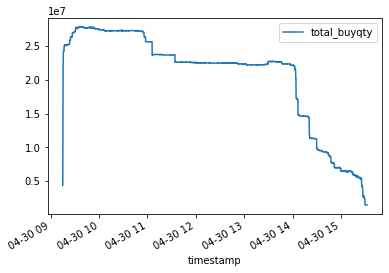

In [178]:
chain.query('name == "FINNIFTY24APR21800CE"')[['timestamp','total_buyqty']].set_index('timestamp').plot()

In [168]:
otms_raw = chain.query('moneyness == 0')

In [169]:
otms_raw.head()

,timestamp,total_buyqty,total_sellqty,name,strike,fut_ltp,opt_type,moneyness,strike_dist
51,2024-04-30 09:15:00.106404+05:30,0.0,7000.0,FINNIFTY24APR21250PE,21250.0,21820.6,PE,0.0,0.0
52,2024-04-30 09:15:00.107567+05:30,853920.0,28560.0,FINNIFTY24APR21550PE,21550.0,21820.6,PE,0.0,0.0
53,2024-04-30 09:15:00.108498+05:30,40.0,17840.0,FINNIFTY24APR21100PE,21100.0,21820.6,PE,0.0,0.0
54,2024-04-30 09:15:00.177317+05:30,1241200.0,4920.0,FINNIFTY24APR23000CE,23000.0,21820.6,CE,0.0,0.0
55,2024-04-30 09:15:00.177317+05:30,166080.0,400.0,FINNIFTY24APR22900CE,22900.0,21820.6,CE,0.0,0.0


In [154]:
otms_raw_resampled = otms_raw.groupby(['name']).apply(lambda x : x.set_index('timestamp').resample('1s').agg({'total_buyqty':'sum',
                                                                                                              'total_sellqty':'sum',
                                                                                                              'opt_type':'first','fut_ltp':'last',
                                                                                                              'strike':'first'})).reset_index().sort_values('timestamp').reset_index(drop=True)

In [ ]:
otms_raw_resampled['']

In [155]:
otms_raw_resampled.head()

,name,timestamp,total_buyqty,total_sellqty,opt_type,fut_ltp,strike
0,FINNIFTY24APR19750PE,2024-04-30 09:15:00+05:30,17520.0,9440.0,PE,21820.6,19750.0
1,FINNIFTY24APR23900CE,2024-04-30 09:15:00+05:30,91800.0,3600.0,CE,21820.6,23900.0
2,FINNIFTY24APR21700PE,2024-04-30 09:15:00+05:30,1866600.0,86120.0,PE,21820.6,21700.0
3,FINNIFTY24APR22100CE,2024-04-30 09:15:00+05:30,3203640.0,34840.0,CE,21820.6,22100.0
4,FINNIFTY24APR19950PE,2024-04-30 09:15:00+05:30,27480.0,5800.0,PE,21820.6,19950.0


In [ ]:
strike,fut,tte,interest,iv,price

In [137]:
otms_qty = otms_raw.pivot_table(index=['timestamp','opt_type'],columns=['strike'],values=['total_buyqty','total_sellqty'],fill_value=0)

In [ ]:
otms_qty = otms_raw.pivot_table(index=['timestamp','opt_type'],columns=['strike'],values=['total_buyqty','total_sellqty'],fill_value=0)

In [139]:
otms_qty.head()

total_buyqty                  \
strike                                         17000.0 17500.0 17900.0   
timestamp                        opt_type                                
2024-04-30 09:15:00.106404+05:30 PE                  0       0       0   
2024-04-30 09:15:00.107567+05:30 PE                  0       0       0   
2024-04-30 09:15:00.108498+05:30 PE                  0       0       0   
2024-04-30 09:15:00.177317+05:30 CE                  0       0       0   
2024-04-30 09:15:00.178196+05:30 CE                  0       0       0   

                                                                           \
strike                                    18000.0 18100.0 18200.0 18300.0   
timestamp                        opt_type                                   
2024-04-30 09:15:00.106404+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.107567+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.108498+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.177317+05:30 CE             0       0       0       0   
2024-04-30 09:15:00.178196+05:30 CE             0       0       0       0   

                                                                           \
strike                                    18400.0 18500.0 18600.0 18700.0   
timestamp                        opt_type                                   
2024-04-30 09:15:00.106404+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.107567+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.108498+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.177317+05:30 CE             0       0       0       0   
2024-04-30 09:15:00.178196+05:30 CE             0       0       0       0   

                                                                           \
strike                                    18800.0 18900.0 19000.0 19100.0   
timestamp                        opt_type                                   
2024-04-30 09:15:00.106404+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.107567+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.108498+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.177317+05:30 CE             0       0       0       0   
2024-04-30 09:15:00.178196+05:30 CE             0       0       0       0   

                                                                           \
strike                                    19200.0 19300.0 19400.0 19450.0   
timestamp                        opt_type                                   
2024-04-30 09:15:00.106404+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.107567+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.108498+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.177317+05:30 CE             0       0       0       0   
2024-04-30 09:15:00.178196+05:30 CE             0       0       0       0   

                                                                           \
strike                                    19500.0 19550.0 19600.0 19650.0   
timestamp                        opt_type                                   
2024-04-30 09:15:00.106404+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.107567+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.108498+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.177317+05:30 CE             0       0       0       0   
2024-04-30 09:15:00.178196+05:30 CE             0       0       0       0   

                                                                           \
strike                                    19700.0 19750.0 19800.0 19850.0   
timestamp                        opt_type                                   
2024-04-30 09:15:00.106404+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.107567+05:30 PE             0       

In [128]:
otms_raw.tail()

,timestamp,total_buyqty,total_sellqty,name,strike,fut_ltp,opt_type,moneyness
1294781,2024-04-30 15:32:25.637301+05:30,99240.0,104160.0,FINNIFTY24APR22150CE,22150.0,21844.0,CE,0.0
1294782,2024-04-30 15:32:25.637301+05:30,0.0,139080.0,FINNIFTY24APR22550CE,22550.0,21844.0,CE,0.0
1294783,2024-04-30 15:32:25.639555+05:30,0.0,131400.0,FINNIFTY24APR22050CE,22050.0,21844.0,CE,0.0
1294785,2024-04-30 15:32:25.639584+05:30,235120.0,381520.0,FINNIFTY24APR21850CE,21850.0,21844.0,CE,0.0
1294786,2024-04-30 15:32:25.639584+05:30,0.0,224920.0,FINNIFTY24APR21900CE,21900.0,21844.0,CE,0.0
